# 🎥 Exploration 9. Movielens 영화 추천하기 🎥

## 🎯 프로젝트 목표 🎯
1. 사용자와 아이템의 수를 바탕으로 정확한 사이즈의 CSR Matrix를 구현할 수 있다.
2. MF 모델이 정상적으로 훈련되며, 사용자와 아이템 벡터 내적수치가 의미있게 형성되면서 그럴듯한 추천을 끌어낼 수 있다.
3. 비슷한 영화를 찾을 수 있고 유저에게 추천하는 과정 등이 정상적으로 진행되도록 할 수 있다.

📢 **본 프로젝트를 수행하기 위한 연습과정이 포함되어 있습니다. 여기에서는 노드 기준 9-3부터 진행 합니다.** 📢

## 9-3. 데이터 탐색, 전처리
- 아래 보이는 Cloud Shell의 내용 중 맨 윗줄 명령어를 입력해주었다.
- 출력된 내용을 보면 행마다 탭으로 구분된 4개의 Column이 존재한다.
- 각각의 column은 **왼쪽부터 순서대로 사용자 ID, 아티스트 MBID, 아티스트 이름, 플레이 횟수**를 나타낸다.

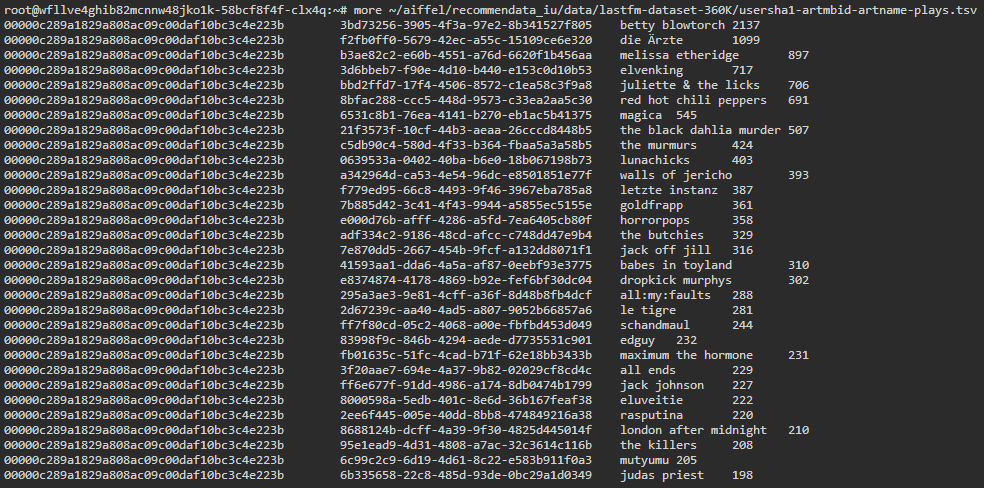

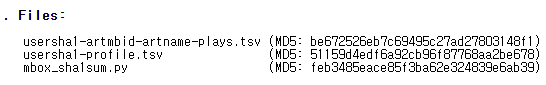

- 이번 프로젝트에서 주로 사용하게 되는 라이브러리는 pandas가 될 것이다.
- pandas는 복잡한 수치나 큰 데이터를 다루는 연산에 적합한 라이브러리로 이번 프로젝트에 적합하다.
- 이제 pandas를 활용해 데이터를 열어 보도록 한다.

In [1]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head()                                                # 노드에서는 10개를 출력했으나 시간 소요 문제로 5개만 출력해보겠습니다.

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


- 우리의 목표는 사용자가 어떤 아티스트의 노래를 몇 번 플레이했는지를 통해 비슷한 아티스트를 찾고 유저에게 추천해주는 시스템을 구현하는 것이다.
- 따라서 artist_MBID는 4개의 Column 특성 중에 가장 적합하지 않다고 보고 해당 Column을 삭제하도록 한다.

In [2]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


- 보다 쉽게 아티스트를 검색할 수 있도록 **lower() 함수를 써서 아티스트 문자열을 모두 소문자로 바꾼다.**
- 여기서 index 1인 행을 살펴보면 A라는 문자 위에 이상한 기호 같은 게 있는데, lower() 함수는 그런 것과는 관계가 없었다.
- A라는 대문자가 있어서 해당 문자열을 소문자 a로 바꾸어 표기하지 않았을까라는 생각을 해볼 수 있지 않을까?

In [3]:
data['artist'] = data['artist'].str.lower() # 검색을 쉽게하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


- 이제, 1번째 유저가 어떤 아티스트의 노래를 듣는지 살펴본다.
- 출력해 보면 1번째 유저 한 명이 서로 다른 아티스트 49명의 노래를 듣는다는 것을 파악할 수 있다.
- 가장 많이 들은 횟수가 무려 **2137회**이다!

In [4]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


- **추천 모델을 만들기 위해 데이터의 기본 정보를 살펴보도록 한다.**
1. 유저 수, 아티스트 수, 인기가 많은 아티스트
2. 유저들이 몇 명의 아티스트의 노래를 듣고 있는지에 대한 통계
3. 유저 플레이 횟수 중앙값에 대한 통계

- **pandas.DataFrame.nunique()** 메서드는 특정 Column에 포함된 유니크한 데이터의 개수를 알아보는 데 유용하게 사용된다.

In [6]:
# 유저 수
data['user_id'].nunique()

358868

In [7]:
# 아티스트 수
data['artist'].nunique()

291346

In [8]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(10)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
Name: user_id, dtype: int64

In [9]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [10]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

- 아래 내용은 연습과정에서의 혼란을 막고자 노드에 있는 코드 그대로 사용한다.
- 아래 내용은 **모델 검증에 사용하기 위한 초기 사용자 정보를 Setting하는 과정**이다.

In [11]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


- 이제 모델에 활용하기 위해 전처리를 해 준다.
- 지금 다루는 데이터에서는 user와 artist 각각에 번호를 붙이는 indexing 작업을 해볼 수 있다.
- **indexing**은 추천시스템이나 자연어 처리 분야에서 자주 사용된다.
- **pandas.DataFrame.unique()** 메서드는 특정 Column에 포함된 유니크한 데이터만을 모아준다. indexing 작업에 유용하다.
- zimin이라는 새로운 유저가 데이터 프레임에 포함되어있어, user_id의 수는 358868 + 1 = 358869가 된다.
- indexing은 0부터 생각한다. 따라서 마지막으로 추가된 유저인 zimin에 대한 idx 값은 358868이 되어야 한다.

In [12]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [14]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다.
print(artist_to_idx['black eyed peas'])

358868
376


In [15]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


- 엄청난 숫자에 당황했을지 모르겠지만, 사실 user_id의 유니크한 데이터의 개수가 358869개였던 것이다.
- 그렇다면 **유저 한 명이 여러 아티스트의 노래를 들었다면 그보다 훨씬 많은 데이터의 row가 만들어지게 되는 것**이다.
- 약 1753만 개나 되는 row의 수가 이를 설명해준다.
- 아무튼, 각 Column 내의 값들이 모두 모델 학습에 사용되도록 정수 인덱스 값으로 변환해줌으로서 전처리를 수행할 수 있었다.

## 9-4. 사용자의 명시적, 암묵적 평가

- 우리의 데이터셋에서 1회만 플레이한 데이터는 전체의 몇 %를 차지하는지 알아본다.
- 실행 결과, **전체 17535660개 중 147740개가 해당**되어 전체의 0.84%를 차지하고 있다.

In [16]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740,17535660
Ratio of only_one over all data is 0.84%


- **명시적 평가** : 좋아요, 별점 등 선호도를 명시적으로 나타낼 수 있는 평가를 의미한다.
- **암묵적 평가** : 그 외 서비스를 사용하면서 자연스럽게 발생하는 비명시적인 방법으로 나타나는 평가를 의미한다.
- 암묵적 평가의 예 : 클릭 수, 검색 기록, 플레이 스킵 횟수 등

- **우리가 앞으로 만들어갈 모델은 암묵적 데이터를 해석하기 위해 몇 가지 규칙을 정해둔다.**
1. 단 한 번이라도 들었으면 '선호'로 간주한다.
2. 플레이 횟수가 높은 아티스트에 대해 가중치를 주어서 더 확실히 좋아함을 표현한다.

- 이것으로 데이터 탐색 및 전처리를 포함한 데이터 준비 과정이 마무리된다.

## 9-5. Matrix Factorization(MF)

- **Matrix Factorization 모델**은 추천 시스템의 모델 중 하나로 '**행렬분해**'를 의미한다.
- 추천 시스템의 더 다양한 모델에 대해 알고 싶다면 링크를 따라 잠시 다녀와도 좋다! (https://blog.naver.com/kiakass/222245698675)

- (m, n) 사이즈의 평가행렬 R을 (m, k) 사이즈의 행렬 P와 (k, n) 사이즈의 행렬 Q로 분해한다.
- 이 때, 평가행렬 R은 P와 Q의 행렬 곱으로 표현가능하게 된다. **(m, k) Matrix * (k, n) Matrix**
- 여기서 k는 m 또는 n 보다 대체로 작은 값이라서 계산 측면에서 유리하다.
- 아이디어는 비교적 단순하지만 이러한 MF 모델은 성능이 좋고 Scalability(확장성)가 좋아서 많이 사용하는 모델이다.

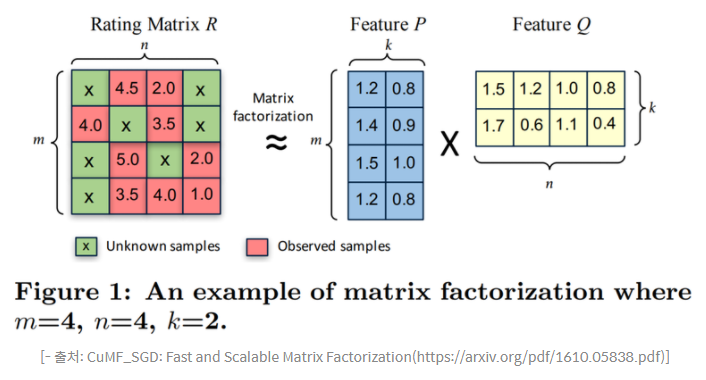

## 9-6. CSR(Compared Sparse Row) Matrix

- MF 모델의 목표는 **모든 사용자와 아이템에 대해 k-dimension의 vector를 잘 만드는 것**이다.
- User i 벡터와 Item j 벡터를 내적했을 때, User i가 Item j에 대해 평가한 수치(M ij)와 비슷한지를 판단한다.

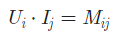

- **유저 × 아이템 평가행렬에 대하여**
1. 유저는 약 36만 명, 아티스트는 약 29만 명이다.
2. 그 행렬의 각 원소에 1Byte의 정수 한 개가 들어간다면 약 97GB라는 엄청난 용량이 필요하다.
3. **평가행렬 안에는 사실 유저가 들어보지 못한 아티스트에 대한 정보까지 모두 행렬에 포함되어 계산**된다.
4. 아까 9-3에서 첫 번째 유저가 노래를 들어본 아티스트 수는 49명이었다. 그 이외에는 들어보지 못한 아티스트일 것이다.
5. 어마어마한 아티스트 수로 인해 평가행렬의 대부분의 공간은 0으로 채워지는데, 이러한 행렬을 **Sparse Matrix**라고 한다.
6. **CSR Matrix**는 이렇듯 97GB나 되는 방대한 행렬에 대해 작업하는 데 있어서 좋은 대안책이 된다.
7. **CSR Matrix**는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성한다.
8. 메모리 사용량을 최소화하면서 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조이다.

- 우리가 가진 데이터를 CSR Matrix에 맞게 바꾸어 본다.

In [17]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Row format>

## 9-7. MF 모델 학습하기

- 이제, MF 모델을 implicit 패키지를 이용하여 학습해볼 것이다.
- **implicit** 패키지는 암묵적인 데이터셋을 사용하는 다양한 모델을 빠르게 학습할 수 있는 패키지이다.
- 그 중에서, 노드에서는 **als(AlternatingLeastSquares) 모델**을 활용한다.
- Matrix Factorization 과정에서 쪼개진 두 개의 특성행렬을 동시에 훈련하면 잘 수렴하지 않는다.
- **AlternatingLeastSquares** 방식은 그에 대한 대안으로, 한 쪽을 고정하고 다른 쪽을 학습하는 방식을 번갈아 수행한다.

In [18]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [19]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [20]:
# als 모델은 input으로 (item X user) 꼴의 matrix를 받기 때문에 Transpose해줍니다.
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Column format>

- 이제 모델을 훈련시켜 보도록 한다. 다소 시간이 소요되는 작업이므로 유의하는 것이 좋다.

In [21]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

- **모델 훈련이 잘 마무리되었다면, 아래 2가지 내용에 주목해본다.**
1. zimin 벡터와 black eyed peas의 벡터를 어떻게 만들고 있는지?
2. 두 벡터를 내적하면 어떤 값이 나오는지?

In [22]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('OK!')

OK!


In [23]:
zimin_vector

array([-0.30192852,  0.04312055, -0.71431947, -0.54288673, -0.15145646,
       -0.2753453 , -0.7114918 ,  0.3573832 ,  0.6188041 ,  1.0864933 ,
        0.38026494,  0.546993  ,  0.81959105,  1.0833434 ,  0.83988565,
        0.6754006 ,  0.13961354,  0.46944463, -0.77728814, -0.3135345 ,
        0.38863423, -0.8196856 , -0.01568145, -0.23379612,  0.20385809,
        0.9319333 ,  0.8763498 ,  1.5322394 ,  0.35816428,  0.74715763,
       -1.399808  ,  0.65172464,  0.45168486,  0.5957938 , -0.7315095 ,
        0.42507485,  0.6735629 , -0.10622807, -0.19105129,  0.13632527,
       -0.31668147,  0.62038165,  0.5909359 ,  0.22032349, -0.14997411,
        0.9494876 ,  0.5357537 ,  1.4519475 , -0.6508986 , -0.13957265,
        0.8075762 , -1.1553231 , -0.13745528, -0.25892502, -0.41483417,
        0.7317653 , -0.09459155,  0.08736278, -0.833715  , -0.759409  ,
        0.6521935 ,  0.20276934,  0.35138977, -1.5684224 , -0.6133098 ,
        0.24546523, -0.75201714, -0.16914238, -0.88566375, -1.03

In [24]:
black_eyed_peas_vector

array([ 1.57227472e-03,  6.72620675e-03, -3.25155677e-03, -1.07248640e-02,
        1.54516567e-03,  1.29261296e-02,  3.66534526e-03,  1.18622445e-02,
        6.84199668e-03,  2.21173186e-02,  1.96748134e-02,  1.73325259e-02,
        5.43549517e-03,  1.74887888e-02,  2.50537484e-03,  4.29988140e-03,
        1.93955482e-03,  2.11986657e-02,  1.53499329e-02,  3.64368688e-03,
        2.03819033e-02,  1.12409936e-02,  8.98402371e-03,  6.47911290e-03,
        7.42921233e-03,  2.43725386e-02,  2.89222598e-02,  2.86996979e-02,
        6.37830887e-03,  6.79240841e-03, -2.23909896e-02,  9.10487771e-03,
        1.13245742e-02,  2.54131071e-02,  9.49385948e-03,  1.04587507e-02,
        9.84170288e-03,  1.15122860e-02,  1.50108924e-02, -5.81701333e-03,
        3.77458823e-03,  1.27911260e-02,  1.28218178e-02,  1.30270107e-03,
        4.57667839e-03,  1.79970022e-02,  2.00748257e-02,  2.56235320e-02,
       -2.04586005e-03,  2.98155379e-03,  2.45737322e-02, -1.37751177e-02,
        3.25257919e-04,  

In [25]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.51418

- zimin이 queen에 대한 선호도를 모델이 어떻게 예측하는지 살펴본다.

In [26]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.3141954

- 추천 시스템은 다른 머신러닝 task보다 객관적으로 평가하는 것이 매우 어려운 분야이다.
- 사람은 저마다 개성이 있고 다른 점이 있기 때문에 도통 알 수 없는 경우가 많다.
- 이로 인해 객관적으로 지표를 결정하는 데 어려움이 따른다.
- 모델을 잘 만들기 위해서는 데이터에 대한 이해가 있어야 한다.

## 9-8. 비슷한 아티스트 찾기, 유저에게 추천하기

- AlternatingLeastSquares 클래스에 있는 similar_items 메서드를 통하여 비슷한 아티스트를 찾는다.
- (artist id, similarity) 형태의 튜플로 반환된다.

In [27]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 1.0000001),
 (277, 0.98620313),
 (28, 0.9816705),
 (5, 0.9748014),
 (490, 0.971148),
 (217, 0.9711096),
 (473, 0.96807176),
 (247, 0.95922816),
 (418, 0.9466645),
 (910, 0.9457559),
 (782, 0.94463366),
 (1018, 0.9431223),
 (694, 0.9411669),
 (55, 0.94078225),
 (268, 0.9404275)]

- artist id를 다시 아티스트 이름으로 Mapping 한다.

In [30]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'red hot chili peppers',
 'oasis',
 'radiohead',
 'placebo',
 'the beatles',
 'u2',
 'nirvana',
 'the white stripes',
 'the smashing pumpkins',
 'foo fighters',
 'arctic monkeys',
 'pink floyd']

- 반복해서 확인 및 편의를 위해 함수를 정의한다.

In [31]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("OK!")

OK!


- 힙합 아티스트 2pac에 대해서 유사 아티스트를 확인해 본다.
- dr. dre, nas, snoop dogg 등의 마니아 힙합 아티스트들이 추천되었음을 알 수 있다.
- '**마니아**'라 함은 특정 관련 장르의 아티스트들에게로 선호도가 집중되는 흐름을 보인다.
- '**마니아**'는 같은 장르의 아티스트들의 벡터도 더 가까워지게 되어 get_similar_artist에서 장르별 특성이 두드러지게 된다.

In [32]:
get_similar_artist('2pac')

['2pac',
 'dr. dre',
 'the game',
 'snoop dogg',
 'notorious b.i.g.',
 '50 cent',
 'nas',
 'jay-z',
 'ice cube',
 'busta rhymes']

- 그렇다면, 여성 아티스트 lady gaga에 대해서 비슷한 아티스트를 알아보자.
- 출력 결과 솔로 혹은 그룹인 여성 아티스트들이 추천되어 있음을 알 수 있다.

In [33]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'christina aguilera',
 'kelly clarkson',
 'leona lewis',
 'justin timberlake']

- 이제 유저에게 아티스트를 추천해 보고자 한다.
- **AlternatingLeastSquares 클래스에 있는 recommend** 메서드를 통하여 좋아할 만한 아티스트를 추천받는다.
- **filter_already_liked_items** 는 유저가 이미 평가한 아이템을 제외하는 인자(Argument)이다.

In [34]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(369, 0.4655757),
 (350, 0.4557752),
 (550, 0.45188147),
 (627, 0.425858),
 (1800, 0.4239359),
 (274, 0.42214477),
 (355, 0.41516554),
 (354, 0.4074164),
 (409, 0.4020741),
 (391, 0.3999884),
 (2249, 0.3937044),
 (564, 0.38868755),
 (901, 0.38179392),
 (724, 0.37927186),
 (621, 0.3693365),
 (5555, 0.3656942),
 (1777, 0.36083093),
 (3005, 0.35374162),
 (618, 0.35155118),
 (382, 0.3507079)]

In [35]:
[idx_to_artist[i[0]] for i in artist_recommended]

['justin timberlake',
 'rihanna',
 'britney spears',
 'maroon 5',
 'lady gaga',
 'michael jackson',
 'madonna',
 'nelly furtado',
 'amy winehouse',
 'christina aguilera',
 'katy perry',
 'kanye west',
 'pink',
 'lily allen',
 'alicia keys',
 'timbaland',
 'mariah carey',
 'duffy',
 'the pussycat dolls',
 'mika']

- 여기서 모델은 왜 rihanna를 추천해 주었을지를 살펴본다.
- **AlternatingLeastSquares 클래스의 explain 메소드**를 활용해, 기록을 남긴 데이터 중 이 추천에 대한 기여도를 확인할 수 있다.

In [36]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [37]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.22194010684568152),
 ('black eyed peas', 0.153096960397466),
 ('coldplay', 0.048590093450414804),
 ('jason mraz', 0.03515324180034366),
 ('maroon5', -0.00042062522182540363)]

- 위의 결과로 보아, beyonce, black eyed peas 등이 가장 크게 기여하였음을 알 수 있다.
- rihanna 뿐만 아니라 beyonce와 black eyed peas도 모두 흑인 아티스트들이다.
- 특히 beyonce와는 같은 성별이어서 black eyed peas에 비해 더 높은 기여도를 내지 않았을까?
- 앞에서 **filter_already_liked_items=True** 로 했는데, maroon 5는 이미 평가한 아이템이 나오고 있다. 이는 implicit 4.2버전의 버그이다.
- 오픈소스 환경에서는 이러한 문제점을 잡아내고 Pull Request를 통해 수정을 제안할 수도 있다.
([예시]https://github.com/benfred/implicit/pull/389)
- Tensorflow, Numpy, Pandas에서도 여러 가지 작은 버그들이 있을 수 있다.
- 이러한 패키지들의 오류를 분석하여 Pull Request를 하고 Contribute를 할 수 있다면 좋은 이력거리가 될 수 있을 것이다.

## 🔮 연습과정 정리 🔮

- 추천 시스템에서 baseline으로 많이 사용되는 Matrix Factorization 기법을 통해 유저에게 아티스트를 추천해 보았다.
- 유저와 아이템에 대한 벡터를 잘 학습하여 유저의 취향에 맞게 아이템을 보여주거나 걸러낼 수 있을 것이다.

## 🎥 9-P. Movielens 영화 추천하기 🎥

### 🎯 프로젝트 목표 🎯
- 사용자와 아이템의 개수를 바탕으로 정확한 사이즈의 CSR Matrix를 만들 수 있다.
- MF 모델이 정상적으로 훈련되며, 이를 바탕으로 그럴듯한 추천이 이루어지게 할 수 있다.
- 비슷한 영화를 찾고 유저에게 추천하는 일련의 과정이 정상적으로 진행되도록 할 수 있다.

### ✨ 프로젝트 활용 데이터 ✨
- 이번 프로젝트에서는 추천 시스템의 MNIST로 불리는 **Movielens 데이터셋**을 활용한다.
- **이 데이터셋은 다음의 가정 아래 활용할 것이다.**
1. 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기별로 존재한다.
2. 여기서는 **Movielens 1M Dataset**을 사용한다.
3. **별점 데이터는 explicit(명시적) 데이터**이다. 다만 implicit(암묵적) 데이터로 간주하고 테스트할 수도 있다.
4. 여기서 별점은 '시청횟수'로 해석한다.
5. 유저가 **3점 미만으로 준 데이터는 선호하지 않는다고 가정**한다.

### ✨ 필요한 라이브러리 로드 및 데이터 준비, 전처리 ✨

- 우선, 추천시스템 구현에 필요한 라이브러리를 로드한다.
- 이전 연습 과정에서 사용했던 라이브러리들을 하나의 코드 블록에 한번에 로드한다.

In [39]:
import pandas as pd
import numpy as np
import os

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

print('필요한 라이브러리 소환!')

필요한 라이브러리 소환!


- 이제 Cloud Shell을 이용하여 아래와 같이 심볼릭 링크로 개인 저장소에 연결하는 것까지는 다음과 같이 하면 된다.

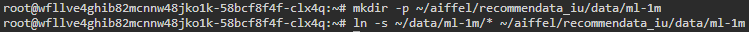

- Movielens 데이터셋의 평점 데이터를 확인해보자.
- 노드와는 다르게 앞쪽 5개 부분이 아닌 **평점이 3점 미만인 데이터가 나오도록 슬라이싱**을 통해 15개의 데이터를 보여주었다.

In [45]:
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings[110:125]

,user_id,movie_id,rating,timestamp
110,2,2312,3,978299046
111,2,265,4,978299026
112,2,1408,3,978299839
113,2,1084,3,978298813
114,2,3699,2,978299173
115,2,480,5,978299809
116,2,1442,4,978299297
117,2,2067,5,978298625
118,2,1265,3,978299712
119,2,1370,5,978299889


- 앞에서 명시한 가정에 따라, 유저가 3점 미만으로 준 데이터는 비선호 데이터로 가정하고 삭제하도록 한다.

In [46]:
# 영화 평점이 3점 이상인 경우에만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


- rating 컬럼의 특성 이름을 count로 재명명한다.

In [47]:
ratings.rename(columns={'rating':'count'}, inplace=True)

In [48]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

- 이제 영화 제목을 보기 위한 메타 데이터를 읽어온다.

In [50]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head(7)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance


### ✨ MF 모델 구성을 위한 분석 ✨

- **아래 내용에 대해서 분석해보면 도움이 된다.**
1. ratings에 있는 unique한 영화의 개수 : **3628개**
2. ratings에 있는 unique한 사용자의 수 : **6039명**
3. 가장 인기가 많은 영화 30개

- pandas에는 **nunique()**라는 메서드가 있다. (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)
- nunique()는 어떠한 데이터셋 안에 있는 unique한 원소의 개수를 세는 역할을 한다.

In [54]:
ratings.nunique()

user_id        6039
movie_id       3628
count             3
timestamp    412911
dtype: int64

In [55]:
ratings['movie_id'].nunique() # movie_id에 대해서만

3628

In [56]:
ratings['user_id'].nunique() # user_id에 대해서만

6039

- 우리는 비슷한 영화를 찾고 다른 사용자에게 이를 추천해 주는 시스템을 구현한다.
- 따라서 이와 관련 없는 컬럼을 삭제하기로 한다.

In [57]:
ratings_ = ratings.join(movies.set_index('movie_id'), on='movie_id')
del ratings_['genre']
del ratings_['timestamp']
ratings_.head()

,user_id,movie_id,count,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,James and the Giant Peach (1996)
2,1,914,3,My Fair Lady (1964)
3,1,3408,4,Erin Brockovich (2000)
4,1,2355,5,"Bug's Life, A (1998)"


In [58]:
best_mv_count = ratings_.groupby('title')['user_id'].count()
best_mv_count.sort_values(ascending=False).head(30) # 내림차순으로 정렬한다. (오름차순 표현에 대해 False 이므로)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

### ✨ 선호하는 영화 5가지에 대해서 ratings에 추가하기 ✨

- 이제, 내가 유저라고 생각하고 내가 가장 선호하는 영화 5가지에 대해 ratings에 추가해 본다.
- 우선, 가장 선호하는 영화가 주어진 데이터셋 내에 있는지 살펴볼 필요가 있다.
- **str.contains(keyword)**를 통해 해당 keyword 문자열을 포함한 영화를 찾는다.
- **keyword 문자열은 대소문자를 구분한다.** Space에 대해서 검색한다면, space는 검색되지 않는다.

In [72]:
# 영화 찾기
movies[movies['title'].str.contains('Space')]

,movie_id,title,genre
667,673,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
1763,1831,Lost in Space (1998),Action|Sci-Fi|Thriller
1855,1924,Plan 9 from Outer Space (1958),Horror|Sci-Fi
1969,2038,"Cat from Outer Space, The (1978)",Children's|Comedy|Sci-Fi
2433,2502,Office Space (1999),Comedy|Romance
2592,2661,It Came from Outer Space (1953),Sci-Fi
2640,2709,Muppets From Space (1999),Children's|Comedy
2964,3033,Spaceballs (1987),Comedy|Sci-Fi
3757,3827,Space Cowboys (2000),Action|Sci-Fi


In [73]:
# 영화 찾기
movies[movies['title'].str.contains('space')]

,movie_id,title,genre
65,66,Lawnmower Man 2: Beyond Cyberspace (1996),Sci-Fi|Thriller


- 이제 이 중에서 5개의 영화를 임의로 골라 Movie List로 만든다. (분명 선호하는 영화 5가지라고 했는데..)
- 사실 영화 이름이 굉장히 많기 때문에 키워드 검색을 활용해서 찾아봤는데 들어봤거나 좋아했던 영화는 없었네요..

In [74]:
# 그나마.. 최신인 5개 영화를 좋아한다고 생각하고..ㅋㅋ
# 좋아하는 영화로 언급했으니까 평점은 5점으로 하겠습니다.
# 이제 리스트를 만듭시다.
my_favorite_title = ['Space Jam (1996)',
                     'Lost in Space (1998)',
                     'Office Space (1999)',
                     'Muppets From Space (1999)',
                     'Space Cowboys (2000)']
my_favorite_id = [673, 1831, 2502, 2709, 3827] # movie_id 값을 넣었습니다.

my_movielist = pd.DataFrame({'user_id': ['Kwon Seung Min']*5, 'movie_id': my_favorite_id, 'count': [5]*5, 'title': my_favorite_title})
my_movielist

,user_id,movie_id,count,title
0,Kwon Seung Min,673,5,Space Jam (1996)
1,Kwon Seung Min,1831,5,Lost in Space (1998)
2,Kwon Seung Min,2502,5,Office Space (1999)
3,Kwon Seung Min,2709,5,Muppets From Space (1999)
4,Kwon Seung Min,3827,5,Space Cowboys (2000)


- 이제, 5개의 영화를 담은 favorite(?) list를 만들었으니 ratings_ 아랫 부분에 만든 데이터 프레임을 첨가한다.

In [75]:
# ratings_에 my_movielist 추가하기
if not ratings_.isin({'user_id':['Kwon Seung Min']})['user_id'].any():
    ratings_ = ratings_.append(my_movielist)                     

ratings_.tail(10)

,user_id,movie_id,count,title
1000203,6040,1090,3,Platoon (1986)
1000205,6040,1094,5,"Crying Game, The (1992)"
1000206,6040,562,5,Welcome to the Dollhouse (1995)
1000207,6040,1096,4,Sophie's Choice (1982)
1000208,6040,1097,4,E.T. the Extra-Terrestrial (1982)
0,Kwon Seung Min,673,5,Space Jam (1996)
1,Kwon Seung Min,1831,5,Lost in Space (1998)
2,Kwon Seung Min,2502,5,Office Space (1999)
3,Kwon Seung Min,2709,5,Muppets From Space (1999)
4,Kwon Seung Min,3827,5,Space Cowboys (2000)


### ✨ CSR Matrix 생성하기 ✨

In [77]:
# unique한 유저, 아티스트 찾기
user_unique = ratings_['user_id'].unique()
movie_unique = ratings_['title'].unique()

# indexing
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [78]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings_['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings_):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings_['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = ratings_['title'].map(movie_to_idx.get).dropna()
if len(temp_artist_data) == len(ratings_):
    print('title column indexing OK!!')
    ratings_['title'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

ratings_

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,count,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
0,6039,673,5,1982
1,6039,1831,5,505
2,6039,2502,5,1023
3,6039,2709,5,1160


In [79]:
# CSR Matrix 생성
num_user = ratings_['user_id'].nunique()
num_movie = ratings_['title'].nunique()

csr_data = csr_matrix((ratings_['count'], (ratings_.user_id, ratings_.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

### ✨ AlternatingLeastSquares 모델 학습시키기 ✨

In [91]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [92]:
# Implicit AlternatingLeastSquares 모델 구성하기
als_model = AlternatingLeastSquares(factors=150, regularization=0.01, use_gpu=False, iterations=12, dtype=np.float32)

In [93]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [94]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/12 [00:00<?, ?it/s]

### ✨ 훈련된 모델이 예측한 나의 선호도 알아보기 ✨

- 내가 선호하는 5가지 영화 중 한 개와 그 외의 영화 중 한 개를 골라서 진행한다.

In [95]:
# 선호하는 영화
kwon, lis = user_to_idx['Kwon Seung Min'], movie_to_idx['Lost in Space (1998)']
kwon_vector, lis_vector = als_model.user_factors[kwon], als_model.item_factors[lis]

In [96]:
kwon_vector

array([ 8.64772141e-01, -6.47297144e-01,  7.24386990e-01, -2.04471067e-01,
        5.22654235e-01,  5.34432300e-04, -7.27059126e-01,  2.65877008e-01,
       -9.59993660e-01, -4.68536854e-01, -1.05241843e-01, -3.71502817e-01,
       -8.22686434e-01,  2.32915774e-01,  6.40851557e-01,  4.53911632e-01,
       -2.71286279e-01,  3.14387351e-01, -5.17353952e-01, -4.25922066e-01,
       -3.96530092e-01,  4.96536285e-01, -6.19352341e-01,  4.94253337e-02,
        1.63902082e-02,  7.68794179e-01,  2.07916107e-02,  6.81799948e-02,
        9.24287260e-01, -2.76790202e-01,  3.53336573e-01, -1.44611582e-01,
       -4.52088937e-02,  5.35443425e-01,  4.78290111e-01, -1.37143880e-01,
       -4.79713619e-01, -6.20606720e-01,  7.46787369e-01, -4.60137427e-02,
        6.55612946e-01, -4.24102396e-01, -5.03073394e-01, -1.67521179e-01,
        5.25870919e-01,  3.73252392e-01, -1.01124622e-01, -4.01778281e-01,
       -2.06389815e-01,  4.64114457e-01, -3.79946470e-01, -1.23185575e-01,
        1.28768250e-01, -

In [97]:
lis_vector

array([ 0.02350232, -0.00635793,  0.00131135,  0.01225341, -0.00498671,
        0.00866879, -0.01609853,  0.00532968,  0.00750348,  0.00071629,
       -0.00504316, -0.01020641, -0.00055153,  0.00780526,  0.01391814,
        0.00856985, -0.0085537 ,  0.00050003,  0.01188383,  0.00315361,
        0.00969444, -0.00075017, -0.01482233, -0.01038026,  0.00148229,
        0.01701749,  0.01048225,  0.00908976,  0.00384486, -0.00962821,
        0.00729651,  0.01236445,  0.00559487,  0.00466879,  0.01403162,
       -0.00112927,  0.00924619, -0.00553203,  0.00468202,  0.00051725,
        0.00938352,  0.02283376, -0.001355  ,  0.00839849,  0.0162196 ,
        0.00571406, -0.00548082, -0.00700219,  0.00131673,  0.00188539,
       -0.00581999,  0.00195272,  0.01554362,  0.00484556, -0.01097073,
        0.01018048,  0.00621346,  0.00588031,  0.00155713, -0.00114883,
       -0.002371  , -0.01119018,  0.00572295, -0.00556326,  0.00521642,
        0.00825052,  0.00577273,  0.00485113,  0.01105265,  0.00

In [101]:
# Lost in Space (1998) 영화에 대한 선호도를 내적계산을 활용해 알아보자.
np.dot(kwon_vector, lis_vector)

0.23631395

- 이 외 선호 리스트에 있는 영화에 대한 선호도는 아래와 같다.

In [103]:
scow = movie_to_idx['Space Cowboys (2000)']
scow_vector = als_model.item_factors[scow]
np.dot(kwon_vector, scow_vector)

0.46919513

In [104]:
sjam = movie_to_idx['Space Jam (1996)']
sjam_vector = als_model.item_factors[sjam]
np.dot(kwon_vector, sjam_vector)

0.25298625

In [105]:
office = movie_to_idx['Office Space (1999)']
office_vector = als_model.item_factors[office]
np.dot(kwon_vector, office_vector)

0.46537206

In [106]:
muppet = movie_to_idx['Muppets From Space (1999)']
muppet_vector = als_model.item_factors[muppet]
np.dot(kwon_vector, muppet_vector)

0.28542614

- 선호 리스트에 없는 영화들 중에도 골라서 같은 방법으로 내적을 계산하면?
- 우선, movies 데이터 프레임을 어느 정도 활용해보자.

In [110]:
movies[1000:1020]

,movie_id,title,genre
1000,1013,"Parent Trap, The (1961)",Children's|Drama
1001,1014,Pollyanna (1960),Children's|Comedy|Drama
1002,1015,Homeward Bound: The Incredible Journey (1993),Adventure|Children's
1003,1016,"Shaggy Dog, The (1959)",Children's|Comedy
1004,1017,Swiss Family Robinson (1960),Adventure|Children's
1005,1018,That Darn Cat! (1965),Children's|Comedy|Mystery
1006,1019,"20,000 Leagues Under the Sea (1954)",Adventure|Children's|Fantasy|Sci-Fi
1007,1020,Cool Runnings (1993),Comedy
1008,1021,Angels in the Outfield (1994),Children's|Comedy
1009,1022,Cinderella (1950),Animation|Children's|Musical


In [99]:
amer = movie_to_idx['American Beauty (1999)']
amer_vector = als_model.item_factors[amer]
np.dot(kwon_vector, amer_vector)

-0.24282898

In [111]:
cin = movie_to_idx['Cinderella (1950)']
cin_vector = als_model.item_factors[cin]
np.dot(kwon_vector, cin_vector)

-0.028522491

In [112]:
dear = movie_to_idx['So Dear to My Heart (1949)']
dear_vector = als_model.item_factors[dear]
np.dot(kwon_vector, dear_vector)

-0.0025657588

### ✨ 내가 선호하는 영화와 비슷한 영화 추천하기 ✨

- 앞에서 선호 영화 5편에 대한 내적을 계산해서 선호도를 알아보았다.
- 그 중에서 가장 높은 값을 보인 Space Cowboys (2000)을 선호 영화로 선택하고, 아래 작업을 수행한다.
- **als_model.similar_items** 메서드를 이용해서 선호 영화를 포함하여 이와 비슷한 다른 영화 19개를 추천받는다.

In [113]:
favorite_movie = 'Space Cowboys (2000)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=20)
similar_movie   # (movie idx, 유사도) Tuple

[(909, 1.0000001),
 (1860, 0.56339544),
 (1661, 0.5589125),
 (1465, 0.53162724),
 (862, 0.5055188),
 (2294, 0.47757524),
 (1500, 0.46814615),
 (2413, 0.46784535),
 (1812, 0.4677096),
 (746, 0.46617934),
 (2826, 0.46014085),
 (820, 0.45837724),
 (2047, 0.45556542),
 (1858, 0.4511257),
 (2243, 0.44706038),
 (3024, 0.44548485),
 (2025, 0.4450418),
 (486, 0.44397086),
 (1826, 0.4362047),
 (2365, 0.4314644)]

- Tuple이 잘 출력된 것을 확인할 수 있었다.
- 그러나 우리가 알고 싶은 것은 **영화별 id값이 아닌 영화의 이름을 알기를 원한다.**
- 따라서 아래와 같이 index로부터 영화의 이름을 얻기 위해 아래와 같이 딕셔너리를 생성한다.

In [114]:
# movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Space Cowboys (2000)',
 'Kid, The (2000)',
 'Replacements, The (2000)',
 'Saving Grace (2000)',
 'Art of War, The (2000)',
 'Autumn in New York (2000)',
 'Nutty Professor II: The Klumps (2000)',
 'Duets (2000)',
 'Godzilla 2000 (Gojira ni-sen mireniamu) (1999)',
 'Perfect Storm, The (2000)',
 'Deterrence (1998)',
 "Big Momma's House (2000)",
 'Coyote Ugly (2000)',
 'Reindeer Games (2000)',
 'Yards, The (1999)',
 'Five Senses, The (1999)',
 'Bait (2000)',
 'Remember the Titans (2000)',
 'Hollow Man (2000)',
 'Adventures of Rocky and Bullwinkle, The (2000)']

- 선호하는 영화와 비슷한 영화가 무엇인지를 추천해주는 함수를 만든다.

In [117]:
def get_similar_movie(movie_title: str):
    movie_id = movie_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [118]:
get_similar_movie('Saving Grace (2000)')

['Saving Grace (2000)',
 'Yards, The (1999)',
 'Duets (2000)',
 'Steal This Movie! (2000)',
 "All the Rage (a.k.a. It's the Rage) (1999)",
 'Five Senses, The (1999)',
 'Tigerland (2000)',
 'Following (1998)',
 'Under Suspicion (2000)',
 'Girlfight (2000)']

- **아래 함수의 실행 결과는?**
1. 아까 전 Space Cowboys (2000)과 유사한 영화를 선호도가 높은 순으로 나열하여 보았다.
2. 아래 함수의 실행 결과는 그 중에서 위에서 10개 영화까지의 결과이다. (선호 영화인 Space Cowboys 포함)

In [119]:
get_similar_movie('Space Cowboys (2000)')

['Space Cowboys (2000)',
 'Kid, The (2000)',
 'Replacements, The (2000)',
 'Saving Grace (2000)',
 'Art of War, The (2000)',
 'Autumn in New York (2000)',
 'Nutty Professor II: The Klumps (2000)',
 'Duets (2000)',
 'Godzilla 2000 (Gojira ni-sen mireniamu) (1999)',
 'Perfect Storm, The (2000)']

- 그렇다면 **왜 get_similar_movie라는 함수는 비슷한 영화를 10개까지 추천했을까**에 대한 의문을 가질 수 있을 것이다.
- 이 부분에 대해서는 곧 나올 회고를 통해 정리하고자 한다.

### ✨ 내가 가장 좋아할 만한 영화들을 추천받아 보기 ✨

In [121]:
user = user_to_idx['Kwon Seung Min']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended    # (movie_id, similarity) 형태의 Tuple로 구성

[(372, 0.23465613),
 (513, 0.2260281),
 (774, 0.20451257),
 (253, 0.20103124),
 (125, 0.19900374),
 (897, 0.1976158),
 (221, 0.18169428),
 (545, 0.16991699),
 (933, 0.16697745),
 (173, 0.1655697),
 (803, 0.16372535),
 (1557, 0.16301063),
 (416, 0.1590533),
 (1508, 0.15649724),
 (811, 0.15441409),
 (126, 0.15365532),
 (596, 0.151397),
 (50, 0.1503043),
 (779, 0.14896671),
 (1635, 0.14845064)]

- 실제 영화를 추천받아야 하므로 movie_id 대신 영화 이름이 나오게 바꾸어 준다.

In [122]:
[idx_to_movie[i[0]] for i in movie_recommended]

['X-Men (2000)',
 'Jumanji (1995)',
 'Titan A.E. (2000)',
 'Mystery Men (1999)',
 'Armageddon (1998)',
 'Bicentennial Man (1999)',
 'South Park: Bigger, Longer and Uncut (1999)',
 'Santa Clause, The (1994)',
 'Wild Wild West (1999)',
 'Dragonheart (1996)',
 'Pushing Tin (1999)',
 'Muppet Treasure Island (1996)',
 'Chasing Amy (1997)',
 'Fantasia 2000 (1999)',
 'Thomas Crown Affair, The (1999)',
 'Shakespeare in Love (1998)',
 'Hook (1991)',
 'Toy Story 2 (1999)',
 'Forever Young (1992)',
 'Dinosaur (2000)']

- 유저가 마지막으로 기록을 남긴 데이터들 중에서 이 추천이 선호영화 5개에 미친 기여도를 확인해본다.

In [130]:
recommended = movie_to_idx['Titan A.E. (2000)']
explain = als_model.explain(user, csr_data, itemid=recommended)

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Space Cowboys (2000)', 0.0876595339736137),
 ('Lost in Space (1998)', 0.04024665060801022),
 ('Space Jam (1996)', 0.03339555953137839),
 ('Muppets From Space (1999)', 0.02831163177251746),
 ('Office Space (1999)', 0.014293482957577566)]

In [129]:
recommended2 = movie_to_idx['X-Men (2000)']
explain = als_model.explain(user, csr_data, itemid=recommended2)

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Space Cowboys (2000)', 0.1367748682046706),
 ('Space Jam (1996)', 0.04103516750434333),
 ('Office Space (1999)', 0.022177798603409023),
 ('Muppets From Space (1999)', 0.01706988084037286),
 ('Lost in Space (1998)', 0.016663359157625963)]

### 🚩 프로젝트 정리 🚩

- **프로젝트 목표를 다시 상기하며 이번 프로젝트를 정리한다.**
1. 사용자와 아이템의 개수를 바탕으로 정확한 사이즈의 CSR Matrix를 만들 수 있다.
2. MF 모델이 정상적으로 훈련되며, 이를 바탕으로 그럴듯한 추천이 이루어지게 할 수 있다.
3. 비슷한 영화를 찾고 유저에게 추천하는 일련의 과정이 정상적으로 진행되도록 할 수 있다.

## 1.

- unique한 유저와 영화의 개수를 파악하고, 그 개수만큼 유저 id와 영화 제목을 indexing 하였다.
- 이 과정을 거쳐서 **6040(user)×3628(movie) 사이즈의 CSR Matrix**를 생성할 수 있었다.
- **6040**은 본인(Kwon Seung Min)을 포함한 unique한 유저의 수를 의미한다.
- **3628**은 unique한 영화의 수를 의미한다.

## 2.

- Matrix Factorization 모델인 **AlternatingLeastSquares 모델을 학습시켰다.**
- 이 모델은 **input로 (item × user)인 행렬을 받기 때문에** 우리가 원하는 모양인 (user × item)으로 **Transpose** 해주었다.
- 그 후 **als_model.fit()를 활용**해서 언급한 모델을 학습시켜주었다.

## 3.

- 선호하는 영화와 비슷한 영화 리스트를 정상적으로 출력할 수 있었다.
- 어떤 유저에게 가장 좋아할 만한 영화를 추천하고, 추천에 기여한 정도를 살펴보았다.

### 🪔 프로젝트 회고 🪔

- **이번에 프로젝트를 하면서 들었던 의문점은 3가지였다.**
1. 프로젝트에서는 유저가 3점 미만의 평점을 준 데이터는 선호하지 않다고 보고 진행했습니다. 만일 평점의 기준을 4점 미만으로 바꾼다면, 추천 시스템의 MF 모델의 성능을 올릴 수 있을까요? (이 부분은 제출기한으로 인해 시간이 없어서 진행하지 못했습니다 ㅠㅠ)
2. get_similar_movie 함수는 왜 비슷한 영화를 10개까지만 추천해 주었을까요?
3. 선호 영화 리스트에 없는 영화에 대한 내적을 계산해서 음수가 나왔는데, 이것은 오류인가요? 혹시 오류가 아니라면 내적 값이 양수일수록 선호도가 높게 예측되어진 것이고, 반대로 내적 값이 음수일수록 선호도가 낮다고 보면 되는 걸까요?
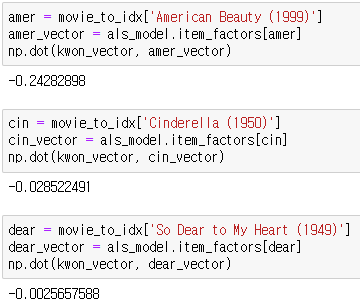

- 이번 프로젝트는 추천시스템을 기반으로 한 프로젝트로 데이터셋이 주어졌을 때 CSR Matrix와 Matrix Factorization 모델을 통해 영화를 추천하는 방법을 실습해 보았습니다.
- 추천 시스템 관련 구현이 처음이라 의문점을 많이 남긴 프로젝트였습니다. 위에 남긴 의문점들은 질풍노드 스터디에서 더 자세히 다루어보고 싶습니다.
- 이번 프로젝트를 하고 나니까 CV, NLP, 추천시스템 중 무엇을 해야 할지 고민이 많이 되는 것 같습니다. 프로젝트 성과와 본인의 흥미를 기반으로 좋은 선택을 할 수 있도록 해야 할 것 같습니다 ^^